In [1]:
import sys
sys.path.append('..')

import torch
from torch.utils.data import DataLoader, random_split
from torch import Generator, nn
from torchvision import datasets
from sklearn.utils.class_weight import compute_class_weight

from semantic_segmentation_voc.transforms import pair_transforms_train, pair_transforms_val
from semantic_segmentation_voc.model import CustomCNNEncoderDecoder
from semantic_segmentation_voc.train import validate
from semantic_segmentation_voc.utils import (
    display_batch_predictions, display_error_analysis, 
    error_analysis_per_image, plot_confusion_matrix
)

/home/tgniazdo/semantic segmentation VOC/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = datasets.VOCSegmentation("data", 
                                    year="2012", 
                                    image_set="train", 
                                    transforms=pair_transforms_train, 
                                    download=False)
all_pixels_values = torch.cat([y.flatten() for _, y in train_ds], dim=0)
class_weights = compute_class_weight("balanced",
                                     classes=list(range(21)) + [255], 
                                     y=all_pixels_values.tolist())[:-1] # without the ignore index (255)

In [3]:
val_test_ds = datasets.VOCSegmentation("data", 
                                       year="2012", 
                                       image_set="val", 
                                       transforms=pair_transforms_val, 
                                       download=False)
val_ds, test_ds = random_split(val_test_ds, [0.5, 0.5], generator=Generator().manual_seed(42))

In [4]:
custom_cnn_encoder_decoder = CustomCNNEncoderDecoder(num_classes=21).to("cuda")
custom_cnn_encoder_decoder.load_state_dict(torch.load("model/best_model.pth"))
custom_cnn_encoder_decoder.eval()

val_dl = DataLoader(val_ds, batch_size=8, shuffle=True) # shuffle to get different images in the next cell
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)

loss_fn = nn.CrossEntropyLoss(ignore_index=255, weight=torch.tensor(class_weights).to(torch.float).to("cuda"))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 644.00it/s]


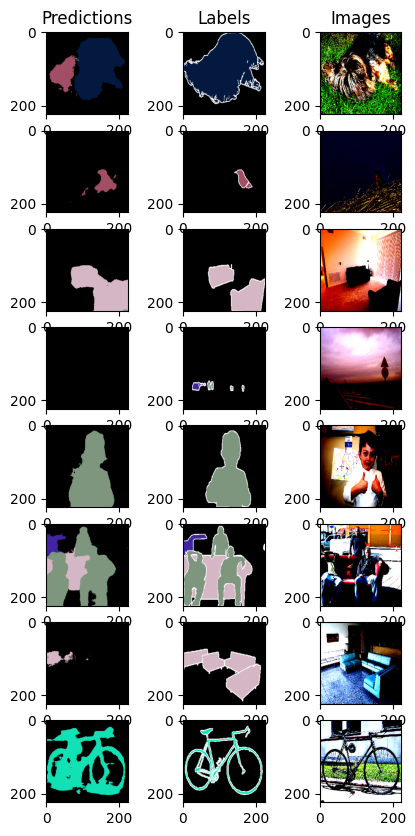

In [9]:
with torch.no_grad():
    for x, y in val_dl:
        x, y = x.to("cuda"), y.to("cuda")
        preds = custom_cnn_encoder_decoder(x)
        display_batch_predictions(
            predictions=preds, 
            labels=y,
            images=x,
            size=10
            )
        break

In [10]:
_, val_acc = validate(
    model=custom_cnn_encoder_decoder, 
    dataloader=val_dl, 
    loss_fn=loss_fn,
    device="cuda"
    )
val_acc

0.8768874406814575

In [11]:
_, test_acc = validate(
    model=custom_cnn_encoder_decoder, 
    dataloader=test_dl, 
    loss_fn=loss_fn,
    device="cuda"
    )
test_acc

0.8794523477554321

In [12]:
all_predictions = []

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to("cuda"), y.to("cuda")
        preds = custom_cnn_encoder_decoder(x)
        all_predictions.append(preds)

all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat([y for _, y in test_dl], dim=0)

error_per_img = error_analysis_per_image(
    predictions=all_predictions,
    labels=all_labels,
    loss_fn=loss_fn,
    device="cuda"
)

In [13]:
error_per_img.head()

,index,prediction,label,loss
0,0,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",3.357262
1,1,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",4.553746
2,2,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",0.145314
3,3,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",1.391203
4,4,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...",1.589908


100%|██████████| 5/5 [00:00<00:00, 4522.65it/s]


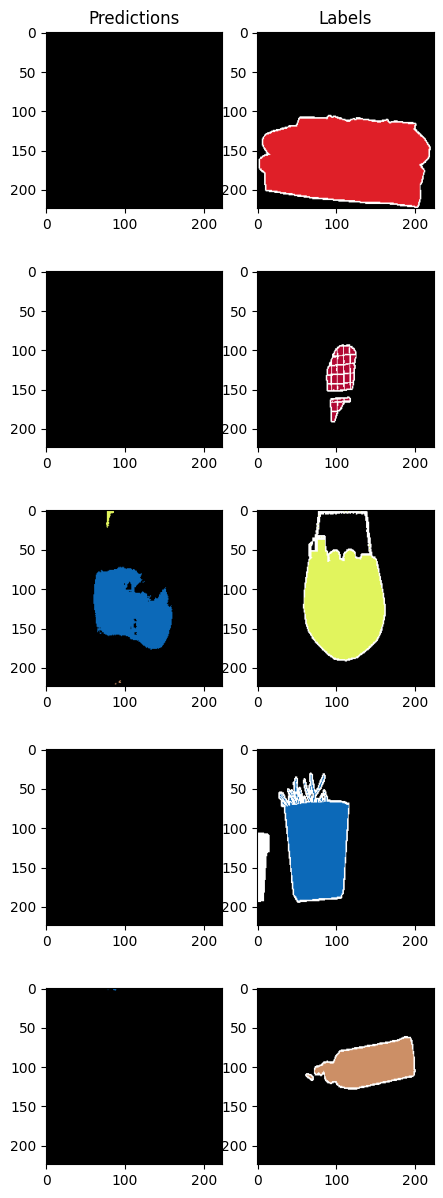

In [14]:
worst_predicted_imgs = error_per_img.sort_values(by="loss", ascending=False).head(5)
display_error_analysis(worst_predicted_imgs, size=15)

100%|██████████| 10/10 [00:00<00:00, 5164.13it/s]


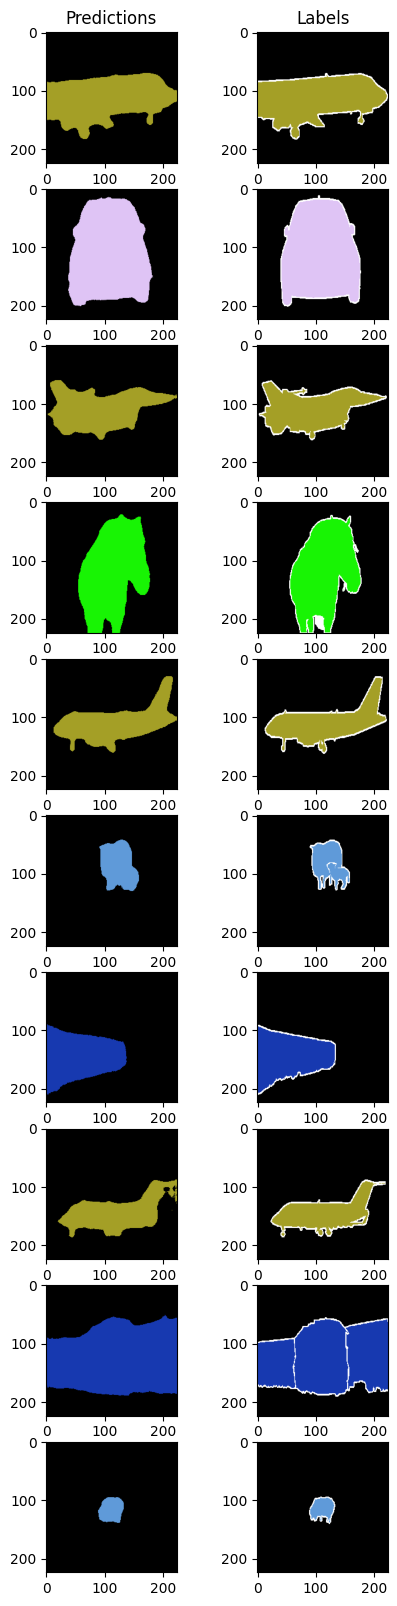

In [15]:
best_predicted_imgs = error_per_img.sort_values(by="loss", ascending=True).head(10)
display_error_analysis(best_predicted_imgs, size=20)

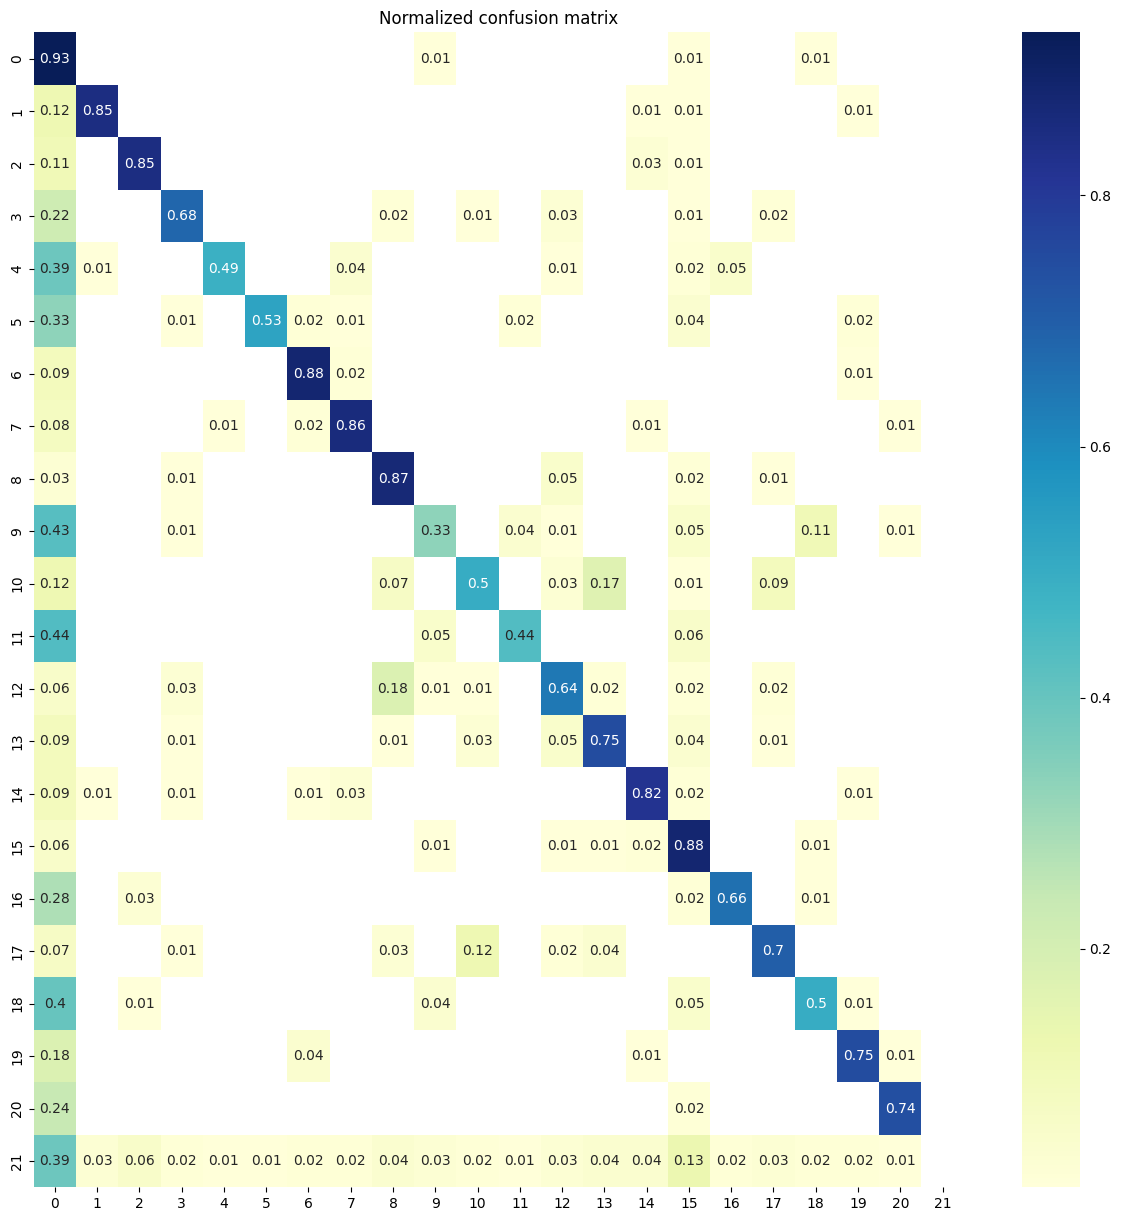

In [16]:
plot_confusion_matrix(
    predictions=all_predictions,
    labels=all_labels
)